In [3]:
using Pkg
Pkg.activate("/psi/home/albajacas_a/data/julia_envs/phd_env")

  Activating project at `~/data/julia_envs/phd_env`


In [69]:
using LinearAlgebra
using BenchmarkTools
using Printf
using Plots

include("Lasso.jl")

uncorrelated_coordinate_descent!

# Simple example

In [63]:
N = 100; d = 20;

In [67]:
function test_Lasso_methods(N, d ;verbose = true)
    X = randn(N,d); Xtest = randn(N,d); normalise!(X,Xtest)
    α = rand(d); α[1:10] = 40.0 .* (rand(10) .- 0.5)  # y = X*α + noise
    noise = 5.5
    y = X * α .+ randn(N)*noise; ytest = Xtest * α; normalise!(y,ytest)

    methods = [:Od,
                :On,
                :wild,
                :Asy,
                # :uncorrelated,
                :SK]
    ts = []; βs = []; λs = []; mses = []; losses = []
    for method in methods
        t = @elapsed locλs, locβs, nIters = lasso_path(X, y, method = method)
        
        loclosses = [mse(ytest, Xtest*locβs[i,:]) for i=1:length(locλs)]
        push!(ts, t)
        push!(βs, locβs[argmin(loclosses),:])
        push!(λs, locλs[argmin(loclosses)]) 
        push!(mses, mse(ytest, Xtest*βs[end]))
        push!(losses, loclosses)
    end


    # Print stuff:
    if verbose
        @printf "MSE with %20s = %.5f\n" "zeros" mse(ytest, zeros(length(ytest)))
        OLStime = @elapsed OLSbeta = pinv(X) * y
        @printf "MSE with %20s = %.5f\n" "OLS" mse(ytest, Xtest*OLSbeta)
        for (i,method) in enumerate(methods)
            @printf "MSE with %20s = %.5f\n" string(method) mses[i]
        end
        println()
        @printf "Time with %20s = %.5f s\n" "OLS" OLStime
        for (i,method) in enumerate(methods)
            @printf "Time with %20s = %.5f s\n" string(method) ts[i]
        end
    end
    return methods, λs, mses, ts
end

test_Lasso_methods (generic function with 1 method)

In [70]:
results = test_Lasso_methods(N, d);

MSE with                zeros = 1.05056
MSE with                  OLS = 0.20428
MSE with                   Od = 0.02722
MSE with                   On = 0.02722
MSE with                 wild = 0.02722
MSE with                  Asy = 0.02722
MSE with                   SK = 0.02720

Time with                  OLS = 0.48279 s
Time with                   Od = 0.91129 s
Time with                   On = 0.62091 s
Time with                 wild = 0.81751 s
Time with                  Asy = 0.72865 s
Time with                   SK = 0.25332 s


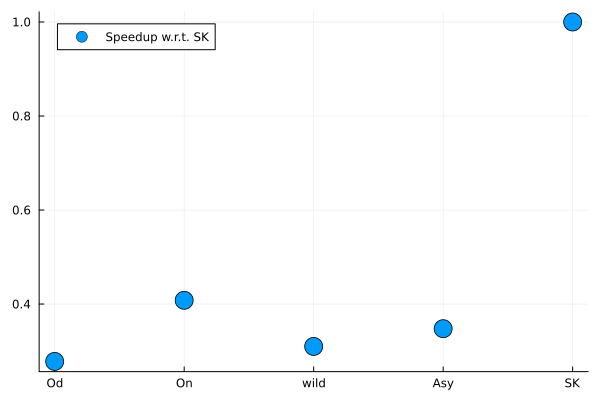

In [77]:
plot()
scatter!(string.(results[1]), results[4][end] ./ results[4], label = "Speedup w.r.t. SK", markersize = 10)
# plot!(yscale = :log)

# Test scaling

In [40]:
function make_data(N,d)
    X = randn(N,d); Xtest = randn(N,d); normalise!(X,Xtest)
    α = rand(d) .- 0.5;
    noise = 0.01
    y = X * α .+ randn(N)*noise; ytest = Xtest * α; normalise!(y,ytest)
    return X, y, Xtest, ytest
end

make_data (generic function with 1 method)

In [60]:
ds = Int.(floor.(10 .^ LinRange(1, 3, 5)))
Ns = Int.(floor.(10 .^ LinRange(1, 3, 6)))
method = :On

mses = zeros(length(ds), length(Ns))
ts = copy(mses)
for (i,d) in enumerate(ds)
    for (j,N) in enumerate(Ns)
        X,y,Xtest,ytest = make_data(N,d)
        ts[i,j] = @elapsed locλs, locβs, nIters = lasso_path(X, y, method = method)
        loclosses = [mse(ytest, Xtest*locβs[i,:]) for i=1:length(locλs)]
        β = locβs[argmin(loclosses),:]
        mses[i,j] = mse(ytest, Xtest*β)
    end
end     

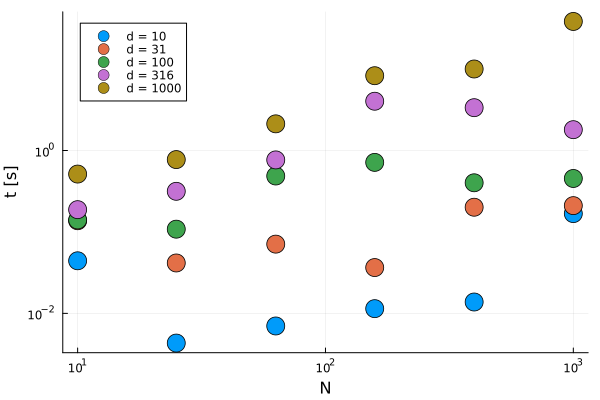

In [61]:
plot()
for (i,d) in enumerate(ds)
    scatter!(Ns, ts[i, :], label = "d = "*string(d), markersize = 10)
end
plot!(xscale = :log, yscale = :log, xlabel = "N", ylabel = "t [s]")